In [1]:
!pip install rdkit

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

In [3]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("Current CUDA device:", torch.cuda.current_device())


PyTorch version: 2.5.1
CUDA available: True
CUDA device count: 1
GPU Name: NVIDIA GeForce RTX 4060 Ti
Current CUDA device: 0


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
train_url = 'https://raw.githubusercontent.com/sussykeem/eos_predictor/refs/heads/main/eos_dataset/train_data.csv'
test_url = 'https://raw.githubusercontent.com/sussykeem/eos_predictor/refs/heads/main/eos_dataset/test_data.csv'

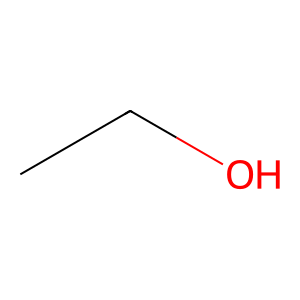

In [6]:
class MoleculeVisualizer():
    def visualize_molecule_2D(self,smiles):
        """
        Generates a 2D image of the molecule from its SMILES representation.
        """
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            print("Invalid SMILES string.")
            return

        img = Draw.MolToImage(mol, size=(300, 300))

        return img

visualizer = MoleculeVisualizer()
visualizer.visualize_molecule_2D('CCO')

In [7]:
train_data = pd.read_csv(train_url)
test_data = pd.read_csv(test_url)

X_cols = ['sci_name','name','cid','smile','Molecular Weight','LogP','TPSA','Rotatable Bonds','H Bond Donors','H Bond Acceptors','Aromatic Rings','Num Rings','Atom Count','coulomb_matrix','embeddings']
y_cols = ['a', 'b']

X_train = train_data[X_cols]
y_train = train_data[y_cols]
X_test = test_data[X_cols]
y_test = test_data[y_cols]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(165, 15) (165, 2) (55, 15) (55, 2)


In [8]:
a_mean = y_train['a'].mean()
b_mean = y_train['b'].mean()

diff = a_mean / b_mean
print(diff)

159.90314965096417


In [9]:
train_imgs = []
test_imgs = []

for smile in X_train['smile']:
    img = MoleculeVisualizer().visualize_molecule_2D(smile)
    train_imgs.append(np.array(img, dtype=np.float32))

for smile in X_test['smile']:
    img = MoleculeVisualizer().visualize_molecule_2D(smile)
    test_imgs.append(np.array(img, dtype=np.float32))

train_imgs = np.array(train_imgs, dtype=np.uint8)
test_imgs = np.array(test_imgs, dtype=np.uint8)

print(train_imgs.shape, test_imgs.shape)

[19:01:02] WARNING: not removing hydrogen atom without neighbors


(165, 300, 300, 3) (55, 300, 300, 3)


In [10]:
class EOSDataset(Dataset):

  def __init__(self, imgs, y, scale=True):
    self.imgs = imgs
    self.y = y.values.astype(np.float32)
    self.transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Separate scalers for a and b
    self.scaler_a = StandardScaler()
    self.scaler_b = StandardScaler()

    # Fit scalers on the respective columns
    if scale:
      self.y[:, 0] = self.scaler_a.fit_transform(self.y[:, 0].reshape(-1, 1)).reshape(-1)
      self.y[:, 1] = self.scaler_b.fit_transform(self.y[:, 1].reshape(-1, 1)).reshape(-1)


  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    img = self.imgs[idx]
    label = self.y[idx]

    img = self.transform(img)

    return img, label

  def transform(self, img):
    return self.transform(img)



In [11]:
class CNN(nn.Module):

  def __init__(self, train_dataset, test_dataset):
    super(CNN, self).__init__()

    self.cnn_pipeline = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=7, padding=1),
        nn.BatchNorm2d(32, affine=False),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=5, padding=2),
        nn.BatchNorm2d(64, affine=False),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128, affine=False),
        nn.ReLU()
    )

    self.fc_pipeline = nn.Sequential(
        nn.Linear(128 * 74 * 74, 128),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(128, 64),
        nn.ReLU(),
    )

    self.output_layer = nn.Linear(64, 2)

    self.train_dataset = train_dataset
    self.test_dataset = test_dataset


    self.train_loader = DataLoader(self.train_dataset, batch_size=32, shuffle=True)
    self.test_loader = DataLoader(self.test_dataset, batch_size=32, shuffle=False)

    self._initialize_weights()

  def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

  # For training model on a and b and getting embedded vector for PKAN
  def forward(self, x, predict=False):
    x = self.cnn_pipeline(x)
    x = torch.flatten(x, 1)
    x = self.fc_pipeline(x)
    if predict:
        x = self.output_layer(x)
    return x

  def unscale_predict(self, x, train=True):
    x = x.detach().cpu().numpy()
    if train:
      scaler_a = self.train_dataset.scaler_a
      scaler_b = self.train_dataset.scaler_b
    else:
      scaler_a = self.test_dataset.scaler_a
      scaler_b = self.test_dataset.scaler_b

    x[:, 0] = scaler_a.inverse_transform(x[:, 0].reshape(-1, 1)).reshape(-1)
    x[:, 1] = scaler_b.inverse_transform(x[:, 1].reshape(-1, 1)).reshape(-1)
    return x

  def weighted_loss(self, outputs, labels):
    criterion = nn.SmoothL1Loss()
    loss = criterion(outputs, labels)
    weight = torch.tensor([1.0, 80], device=device)  # Adjust if needed
    return (loss * weight).mean()

  def train_model(self, epochs, learning_rate, step_size, gamma):
    optimizer = optim.Adam(self.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    self.to(device)  # Move the model to the device (GPU if available)

    loss_history = []

    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(self.train_loader, 0):
            inputs, labels = data  # Get the inputs and labels from the data loader
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to device

            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = self(inputs, predict=True)  # Forward pass
            loss = self.weighted_loss(outputs, labels)  # Calculate the loss
            loss_history.append(loss.item())
            loss.backward()  # Backpropagation
            optimizer.step()  # Update the model's parameters

            running_loss += loss.item()  # Accumulate the loss for the epoch

        scheduler.step()

        # Print the average loss for the epoch
        print(f"Epoch [{epoch + 1}/{epochs}] Loss: {running_loss / len(self.train_loader):.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

    plt.figure()
    plt.plot(loss_history)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    print("Training finished!")

    self.to(device)

  def validate(self):
      total_loss = 0.0
      all_outputs = []
      all_labels = []

      with torch.no_grad():  # Disable gradient computation
          for data in self.test_loader:
              inputs, labels = data
              inputs, labels = inputs.to(device), labels.to(device)

              outputs = self(inputs, predict=True)
              loss = self.weighted_loss(outputs, labels)
              total_loss += loss.item()

              all_outputs.append(outputs.cpu().numpy())
              all_labels.append(labels.cpu().numpy())

      avg_loss = total_loss / len(self.test_loader)
      print(f"Validation Loss: {avg_loss:.4f}")

      # Convert lists to numpy arrays for better analysis
      all_outputs = np.concatenate(all_outputs, axis=0)
      all_labels = np.concatenate(all_labels, axis=0)

      # Unscale predictions
      unscaled_outputs = self.unscale_predict(torch.tensor(all_outputs), train=False)
      unscaled_labels = self.unscale_predict(torch.tensor(all_labels), train=False)

      # Compute evaluation metrics
      mae = np.mean(np.abs(unscaled_outputs - unscaled_labels), axis=0)
      mse = np.mean((unscaled_outputs - unscaled_labels) ** 2, axis=0)

      print(f"Mean Absolute Error (MAE): a={mae[0]:.4f}, b={mae[1]:.4f}")
      print(f"Mean Squared Error (MSE): a={mse[0]:.4f}, b={mse[1]:.4f}")



In [12]:
train_dataset = EOSDataset(train_imgs, y_train, True)
test_dataset = EOSDataset(test_imgs, y_test, True)

Epoch [1/100] Loss: 209.1842 | LR: 0.000100
Epoch [2/100] Loss: 152.2990 | LR: 0.000100
Epoch [3/100] Loss: 107.6276 | LR: 0.000100
Epoch [4/100] Loss: 99.4442 | LR: 0.000100
Epoch [5/100] Loss: 84.4047 | LR: 0.000100
Epoch [6/100] Loss: 69.5814 | LR: 0.000100
Epoch [7/100] Loss: 49.3068 | LR: 0.000100
Epoch [8/100] Loss: 30.9552 | LR: 0.000100
Epoch [9/100] Loss: 24.2376 | LR: 0.000100
Epoch [10/100] Loss: 16.7981 | LR: 0.000090
Epoch [11/100] Loss: 16.4456 | LR: 0.000090
Epoch [12/100] Loss: 13.9017 | LR: 0.000090
Epoch [13/100] Loss: 7.4557 | LR: 0.000090
Epoch [14/100] Loss: 6.4782 | LR: 0.000090
Epoch [15/100] Loss: 4.9888 | LR: 0.000090
Epoch [16/100] Loss: 5.1938 | LR: 0.000090
Epoch [17/100] Loss: 5.7301 | LR: 0.000090
Epoch [18/100] Loss: 4.9263 | LR: 0.000090
Epoch [19/100] Loss: 5.3028 | LR: 0.000090
Epoch [20/100] Loss: 4.9834 | LR: 0.000081
Epoch [21/100] Loss: 8.2430 | LR: 0.000081
Epoch [22/100] Loss: 6.3060 | LR: 0.000081
Epoch [23/100] Loss: 5.0853 | LR: 0.000081
Epoch

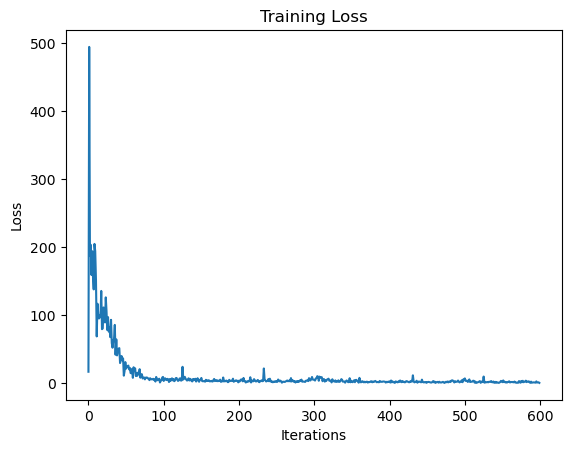

Training finished!


In [13]:
cnn = CNN(train_dataset, test_dataset)
cnn.train_model(epochs=100, learning_rate=0.0001, step_size=10, gamma=0.9)

In [14]:
cnn.validate()

Validation Loss: 10.6962
Mean Absolute Error (MAE): a=8.0623, b=0.0409
Mean Squared Error (MSE): a=135.3195, b=0.0077


In [15]:
img, label = train_dataset.__getitem__(50)

print(cnn.unscale_predict(torch.tensor(label.reshape(-1,2)).to(device)))
encoding = cnn.unscale_predict(cnn(img.to(device).unsqueeze(0), predict=True))

print(encoding)

[[4.1919994 0.05156  ]]
[[0.14622308 0.03478023]]


In [16]:
class KANLayer(nn.Module):

    def __init__(self, input_dim, output_dim, num_kernels=10):

        super(KANLayer, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_kernels = num_kernels

        self.weights = nn.Parameter(torch.randn(self.output_dim, self.num_kernels))
        self.bias = nn.Parameter(torch.zeros(self.output_dim))

        self.centers = nn.Parameter(torch.linspace(-1, 1, self.num_kernels))
        self.widths = nn.Parameter(torch.ones(self.num_kernels) * 0.1)

    def forward(self, x):

        kernels = torch.exp(-((x.unsqueeze(-1) - self.centers) ** 2) / (2 * self.widths ** 2))
        activation = torch.sum(torch.matmul(kernels, self.weights.T), dim=-1)  + self.bias

        return activation

In [17]:
class PKAN(nn.Module):

    def __init__(self, encoder, kan_layer, feature_vec_size=64):
        super(PKAN, self).__init__()

        self.encoder = encoder

        for param in self.encoder.parameters():
            param.requires_grad = False

        self.KAN_layer = kan_layer

        self.fc_pipeline = nn.Sequential(
            nn.Linear(feature_vec_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            self.KAN_layer,
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        with torch.no_grad():
            x = self.encoder(x, predict=False)
        x = self.fc_pipeline(x)
        return x

In [18]:
def train_pkan(model, train_loader, epochs=20, learning_rate=1e-3, step_size=10, gamma=0.8):
    """Train the PKAN model with a frozen CNN encoder."""
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    criterion = nn.SmoothL1Loss()  # Huber loss

    model.to(device)  # Move model to GPU if available
    loss_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            loss_history.append(loss.item())

        scheduler.step()
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss / len(train_loader):.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

    plt.figure()
    plt.plot(loss_history)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('PKAN Training Loss')
    plt.show()

    print("PKAN Training Complete!")


Epoch [1/100] Loss: 0.5695 | LR: 0.001000
Epoch [2/100] Loss: 0.2079 | LR: 0.001000
Epoch [3/100] Loss: 0.0964 | LR: 0.001000
Epoch [4/100] Loss: 0.0940 | LR: 0.001000
Epoch [5/100] Loss: 0.0833 | LR: 0.001000
Epoch [6/100] Loss: 0.0390 | LR: 0.001000
Epoch [7/100] Loss: 0.0371 | LR: 0.001000
Epoch [8/100] Loss: 0.0476 | LR: 0.001000
Epoch [9/100] Loss: 0.0319 | LR: 0.001000
Epoch [10/100] Loss: 0.0273 | LR: 0.000800
Epoch [11/100] Loss: 0.0291 | LR: 0.000800
Epoch [12/100] Loss: 0.0222 | LR: 0.000800
Epoch [13/100] Loss: 0.0253 | LR: 0.000800
Epoch [14/100] Loss: 0.0247 | LR: 0.000800
Epoch [15/100] Loss: 0.0450 | LR: 0.000800
Epoch [16/100] Loss: 0.0247 | LR: 0.000800
Epoch [17/100] Loss: 0.0193 | LR: 0.000800
Epoch [18/100] Loss: 0.0186 | LR: 0.000800
Epoch [19/100] Loss: 0.0152 | LR: 0.000800
Epoch [20/100] Loss: 0.0198 | LR: 0.000640
Epoch [21/100] Loss: 0.0567 | LR: 0.000640
Epoch [22/100] Loss: 0.0279 | LR: 0.000640
Epoch [23/100] Loss: 0.0197 | LR: 0.000640
Epoch [24/100] Loss:

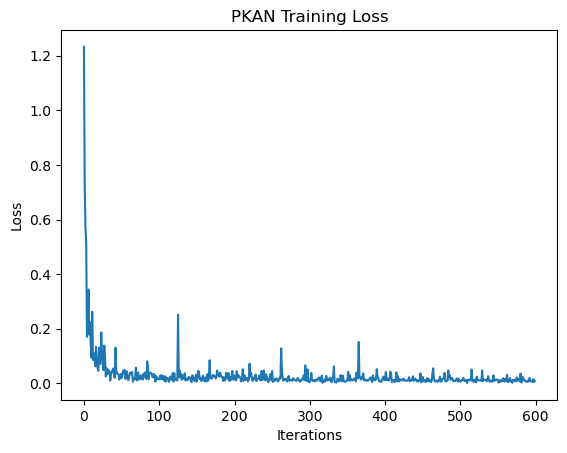

PKAN Training Complete!


In [19]:
kan_layer = KANLayer(64, 64)

pkan = PKAN(cnn, kan_layer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

train_pkan(pkan, train_loader, epochs=100)

In [20]:
def validate_pkan(model, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    all_outputs = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for data in model.encoder.test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)  # Forward pass through PKAN
            loss = model.encoder.weighted_loss(outputs, labels)  # Use CNN's loss function
            total_loss += loss.item()

            all_outputs.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    avg_loss = total_loss / len(model.encoder.test_loader)
    print(f"Validation Loss: {avg_loss:.4f}")

    # Convert lists to numpy arrays for further evaluation
    all_outputs = np.concatenate(all_outputs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Unscale predictions and labels
    unscaled_outputs = model.encoder.unscale_predict(torch.tensor(all_outputs), train=False)
    unscaled_labels = model.encoder.unscale_predict(torch.tensor(all_labels), train=False)

    # Compute evaluation metrics
    mae = np.mean(np.abs(unscaled_outputs - unscaled_labels), axis=0)
    mse = np.mean((unscaled_outputs - unscaled_labels) ** 2, axis=0)

    print(f"Mean Absolute Error (MAE): a={mae[0]:.4f}, b={mae[1]:.4f}")
    print(f"Mean Squared Error (MSE): a={mse[0]:.4f}, b={mse[1]:.4f}")

    return avg_loss, mae, mse


In [21]:
validate_pkan(pkan, device)

Validation Loss: 10.1617
Mean Absolute Error (MAE): a=7.7393, b=0.0389
Mean Squared Error (MSE): a=123.6207, b=0.0078


(10.161663055419922,
 array([7.7393293 , 0.03889797], dtype=float32),
 array([1.23620735e+02, 7.78423203e-03], dtype=float32))